In [1]:
import os
import glob
import rasterio as rio
from rasterio.mask import raster_geometry_mask
from rasterio import plot
from rasterio.plot import show
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns

import pyproj
#from scipy.interpolate import griddata
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform
import geopandas as gpd

In [2]:
# Open the test image of keuka and south Seneca Lake

img_file = "/Users/kathleenkanaley/Downloads/keuka_southseneca_may14_psscene_analytic_8b_sr_udm2/composite.tif"

# Load the geojson with the vineyard geometries

vineyards = '/Users/kathleenkanaley/Downloads/Finger_Lakes_Mega_Farm.geojson'



In [17]:
# Functions

# Get vineyard masks

def get_vineyard_masks(geojson_path, ref_img_path):
    '''This function generates a mask that leaves only pixels inside 
    vine panels unmasked. 
    
    Inputs:
    geojson_path (str): path to a geojson file with the panel geometries. 
    Must be in same CRS as image, otherwise un-comment code section starting with "dst_crs".
    ref_img_path (str): path to the .tif file for the image
    
    Outputs:
    A list of masks, as Boolean arrays. True values are masked pixels.
    False values are unmasked pixels.
    '''
    with open(geojson_path, 'r') as f:
        vineyards = json.load(f)
        features = vineyards['features']
        #features_ordered = sorted(features, key= lambda feature:(feature['properties']['row'],feature['properties']['panel'])) # ground truth order.
        vineyard_aois = [f['geometry'] for f in features]
    
    with rio.open(ref_img_path) as src:
        dst_crs = src.crs
        
        # geojson features (the field block geometries)
        # are often in WGS84
        # project these to the image coordinates
        wgs84 = pyproj.CRS('EPSG:4326')

        project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
        proj_vineyard_aois = [transform(project, shape(p)) for p in vineyard_aois]

        masks = [raster_geometry_mask(src, [p], crop=False)[0]
                 for p in proj_vineyard_aois]                       
    return masks

# Get reflectance df

# def get_rfl(img_path, masks):
#     '''
#     Function to extract per-panel reflectance values for 4-band SkySat images.
#     Calculates the mean reflectance values for the pixels in each panel.
#     The output is formatted as a pandas dataframe.
    
#     Inputs:
#     img_path - abs. path to the image       
#     masks - a list of masks that correspond to the panel aois. 
#     '''
    
#     with rio.open(img_path,'r') as img:
#         def _get_stats(mask, panel_number):
#             panel_blue = np.ma.mean(np.ma.array(img.read(1), mask=mask))/10000
#             panel_green = np.ma.mean(np.ma.array(img.read(2), mask=mask))/10000
#             panel_red = np.ma.mean(np.ma.array(img.read(3), mask=mask))/10000
#             panel_nir = np.ma.mean(np.ma.array(img.read(4), mask=mask))/10000
            
#             return {'acquired': img_path.split('/')[-1].split('_')[-5], # date from image filename
#                     'plot': panel_number + 1,    #add one - panels are numbered starting at 1 in the 'real world'
#                     'blue': panel_blue,
#                     'green': panel_green,
#                     'red': panel_red,
#                     'nir': panel_nir}
#         data = [_get_stats(m, i) for i, m in enumerate(masks)]  # sets the parameters for the nested function as the mask (m) and corresponding panel number (i). 
#         df = pd.DataFrame(data)
    
#     return df

In [10]:
vineyard_data = gpd.read_file('/Users/kathleenkanaley/Downloads/Finger_Lakes_Mega_Farm.geojson')
#len(vineyard_data)
print(vineyard_data.head())

                blockId                       name description  \
0  01qrClnDL4tOk8B0fhqa       White Pine Vineyards               
1  02pMzI3RCGavxXwLTZJx                   Bob Ruis               
2  047Irkig673Hr4YHge78  Hermann J Wiemer Vineyard               
3  06A3W08XdHRWa8wkfFUh              Phillip Davis               
4  07COojX7HwxinOeU2J3P                      Knapp               

                                           updatedOn  hectares     acres  \
0  {'_seconds': 1681499142, '_nanoseconds': 82500...  0.237605  0.587114   
1  {'_seconds': 1681499142, '_nanoseconds': 73800...  0.299662  0.740455   
2  {'_seconds': 1681499142, '_nanoseconds': 86500...  0.250326  0.618548   
3  {'_seconds': 1681499142, '_nanoseconds': 81100...  0.417132  1.030719   
4  {'_seconds': 1681499142, '_nanoseconds': 72200...  0.496531  1.226911   

                       Owner Rtstck_Cln Est_Year           Notes  ...  \
0       White Pine Vineyards          0     2009  6x9 ft spacing  ...   


In [11]:
vineyard_data.County.unique()

array(['Wayne', 'Seneca', 'Yates', 'Schuyler', 'Ontario', 'Steuben',
       'Tompkins', 'Cayuga', 'Onandaga', ''], dtype=object)

In [16]:
vineyards_south = vineyard_data[vineyard_data['County'].isin(['Schuyler','Steuben', 'Yates'])]
#len(vineyards_south)
#vineyards_south[vineyards_south['Acres']>=10]
doyle_simmons = vineyards_south[vineyards_south['name'].isin(['Mike Doyle','Neil Simmons'])]

In [20]:
geometries = doyle_simmons['geometry']

In [21]:
with rio.open(img_file) as src:
        dst_crs = src.crs
        
        # geojson features (the field block geometries)
        # are often in WGS84
        # project these to the image coordinates
        wgs84 = pyproj.CRS('EPSG:4326')

        project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
        proj_vineyard_aois = [transform(project, shape(g)) for g in geometries]

        masks = [raster_geometry_mask(src, [p], crop=False)[0]
                 for p in proj_vineyard_aois]                       
len(masks)

/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are 

99

In [ ]:
with rio.open(img_file,'r') as img:
    def _get_stats(mask, vineyard_number):

        red = np.ma.array(img.read(6), mask=mask)
        nir = np.ma.array(img.read(8), mask=mask)
            
        np.seterr(divide='ignore', invalid='ignore')
            
        ndvi = (nir - red)/(nir + red)
            
        mean_ndvi = np.ma.mean(ndvi)
            
        return {'acquired': img_file.split('/')[-2].split('_')[-6], # date from image filename
                    'vineyard_num': vineyard_number,
                    'ndvi': mean_ndvi}
        
    data = [_get_stats(m, i) for i, m in enumerate(masks)]  # sets the parameters for the nested function as the mask (m) and corresponding vineyard number (i). 
    df = pd.DataFrame(data)

df

# First, clip the image to the vineyard of interest


In [2]:
# Clip all images to the desired aoi.

# def clip_to_aoi(path_to_aoi, img_path):
#     '''This function clips an image to an area of interest (aoi).
#     Inputs:
#     path_to_aoi: the absolute path to a geojson file for the aoi - this needs to be in EPSG 4326
#     img_path: absolute path name for the image to clip.
    
#     Output: saves the clipped image as a .tif file to the same directory where the original image is stored'''
    
#     with open(path_to_aoi, 'r') as f:
#         aoi = json.load(f)
#     aoi_geom = aoi['features'][0]['geometry']
    
#     # find the coordinate reference system of the image
#     with rio.open(img_path) as src:
#         dst_crs = src.crs
#         wgs84 = pyproj.CRS('EPSG:4326')
#         project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
#         proj_aoi = transform(project, shape(aoi_geom))
        
#         mask, mask_transform = rio.mask.mask(src, [proj_aoi], crop=True)
#         mask_meta = src.meta
#         mask_meta.update({"driver": "GTiff",
#                           "height": mask.shape[1],
#                           "width": mask.shape[2],
#                           "transform": mask_transform})
        
#         with rio.open(str(os.path.abspath(img_path).split('.tif')[0])+"_clipped.tif", "w", **mask_meta) as dest:
#             dest.write(mask)   

In [4]:
# Open the image and read as an array

img_path ='/Users/kathleenkanaley/Desktop/frost_dmg/20220828_151645_10_2262_3B_AnalyticMS_SR_8b_harmonized_clip.tif'
with rio.open(img_path) as src:
    image_arr = src.read()

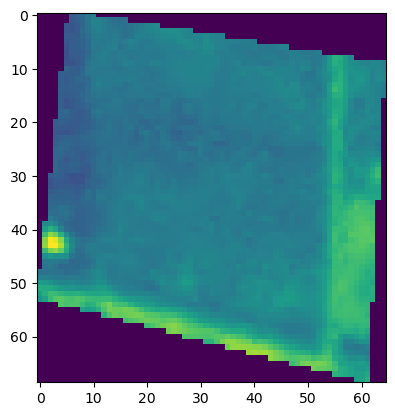

In [5]:
# Plot the first band of the image 

plt.imshow(image_arr[1]) # replace '1' with any band number to visualize other bands

In [6]:
# # Clip the image to the area of interest
# path_to_aoi = '/Users/kathleenkanaley/Desktop/frost_dmg/chardonnay_2020.geojson'

# clip_to_aoi(path_to_aoi, img_path)


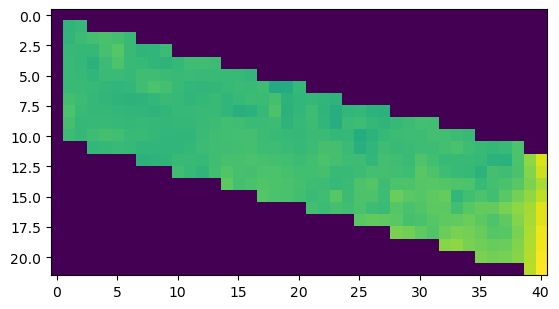

In [7]:
# # Take a look at clipped image

# with rio.open('/Users/kathleenkanaley/Desktop/frost_dmg/20220828_151645_10_2262_3B_AnalyticMS_SR_8b_harmonized_clip_clipped.tif') as src:
#     clipped_arr = src.read()

# plt.imshow(clipped_arr[1])

## Extract NDVI for the clipped image and store in a dataframe with the associated vineyard name and geometry

In [8]:
# # Extract NDVI

# def add_ndvi(image) :
#     '''Calculates the normalized difference vegetation index for each pixel
#     in an image and adds it as a band.
    
#     image: (string) path to raster
    
#     returns: image with an ndvi band'''
    
    
#     with rio.open(image) as src:
#         raster_arr = src.read()
    
#     # modify with appropriate band numbers
    
#     red = raster_arr[6]
#     nir = raster_arr[8]
 
    
#     np.seterr(divide='ignore', invalid='ignore')
    

#     ndvi = ((nir - red)/(nir + red)).reshape(1,raster_arr.shape[1], raster_arr.shape[2])

    
#     stacked_arr = np.vstack([raster_arr, ndvi])

    
#     # Save stacked array as raster
#     with rio.open(image) as src:
#         kwargs = src.meta
#         band_ct = stacked_arr.shape[0]
#         kwargs.update(dtype=rio.float32, count=band_ct)
        
#         with rio.open(str(os.path.split(image)[0])+'/NDVI_'+str(os.path.basename(image)), 'w', **kwargs) as dst:
#             for b in range(stacked_arr.shape[0]):
#                 dst.write_band(b+1, stacked_arr[b].astype(rio.float32))


## Get NDVI just for vineyards - geojsons to mask

In [43]:
# Get vineyard masks

def get_vineyard_masks(geojson_paths, ref_img_path):
    '''This function generates a mask that leaves only pixels inside 
    vine panels unmasked. 
    
    Inputs:
    geojson_paths (list): list of paths to geojson files with the vineyard geometries. 
    Must be in same CRS as image, otherwise un-comment code section starting with "dst_crs".
    ref_img_path (str): path to the .tif file for the image
    
    Outputs:
    A list of masks, as Boolean arrays. True values are masked pixels.
    False values are unmasked pixels.
    '''
    
    masks = []
    
    for path in geojson_paths:
        with open(path, 'r') as v:
            vineyard = json.load(v)
            features = vineyard['features']
            vineyard_aois = [f['geometry'] for f in features]
            
        with rio.open(ref_img_path) as src:
            dst_crs = src.crs
            # geojson features (the vineyard block geometries)
            # are often in WGS84
            # project these to the image coordinates
            
            wgs84 = pyproj.CRS('EPSG:4326')
            project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
            proj_vineyard_aois = [transform(project, shape(v)) for v in vineyard_aois]
            
            masks.append([raster_geometry_mask(src, [v], crop=False)[0] for v in proj_vineyard_aois])
            
    return masks

# Get ndvi df

def get_ndvi_df(img_path, masks):
    '''
    Function to extract per-vineyard mean NDVI from satellite images.
    The output is formatted as a pandas dataframe.
    
    Inputs:
    img_path - abs. path to the image       
    masks - a list of masks that correspond to the vineyard aois. 
    
    Output:
    pandas df with date of image acquisition, vineyard number, and mean ndvi.
    
    '''
    
    with rio.open(img_path,'r') as img:
        def _get_stats(mask, vineyard_number):

            red = np.ma.array(img.read(6), mask=mask)
            nir = np.ma.array(img.read(8), mask=mask)
            
            np.seterr(divide='ignore', invalid='ignore')
            
            ndvi = (nir - red)/(nir + red)
            
            mean_ndvi = np.ma.mean(ndvi)
            
            return {'acquired': img_path.split('/')[-1].split('_')[-10], # date from image filename
                    'vineyard_num': vineyard_number,
                    'ndvi': mean_ndvi}
        
        data = [_get_stats(m, i) for i, m in enumerate(masks)]  # sets the parameters for the nested function as the mask (m) and corresponding vineyard number (i). 
        df = pd.DataFrame(data)
    
    return df

In [41]:
geojsons = ['/Users/kathleenkanaley/Desktop/frost_dmg/chardonnay_2020.geojson',
            '/Users/kathleenkanaley/Desktop/frost_dmg/pm_trial.geojson']

# Test 

masks = get_vineyard_masks(geojsons, img_path)

In [42]:
len(masks)

2

In [39]:
get_ndvi_df(img_path, masks)

,acquired,vineyard_num,ndvi
0,20220828,0,0.731443
1,20220828,1,0.754770


In [59]:
# Try getting masks with coords


for path in geojsons:
    with open(path, 'r') as v:
        vineyard = json.load(v)
        features = vineyard['features']
        vineyard_aois = [f['geometry'] for f in features]
        vineyard_names = os.path.split(path)[-1]#.split('_')[-10]
        mask_dict = dict.fromkeys(vineyard_names)
    print(vineyard_aois)
    print(mask_dict)

#         with rio.open(ref_img_path) as src:
#             dst_crs = src.crs
#             # geojson features (the vineyard block geometries)
#             # are often in WGS84
#             # project these to the image coordinates
            
#             wgs84 = pyproj.CRS('EPSG:4326')
#             project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
#             proj_vineyard_aois = [transform(project, shape(v)) for v in vineyard_aois]
            
#             masks.append([raster_geometry_mask(src, [v], crop=False)[0] for v in proj_vineyard_aois])
            
#     return masks
    

[{'type': 'MultiPolygon', 'coordinates': [[[[-77.0166863002458, 42.878546829802836], [-77.01668601092757, 42.87881557045253], [-77.01521716887808, 42.87853811895566], [-77.01521574330846, 42.878272069225204], [-77.0166863002458, 42.878546829802836]]]]}]
{'c': None, 'h': None, 'a': None, 'r': None, 'd': None, 'o': None, 'n': None, 'y': None, '_': None, '2': None, '0': None, '.': None, 'g': None, 'e': None, 'j': None, 's': None}
[{'type': 'MultiPolygon', 'coordinates': [[[[-77.01667925810412, 42.87883468145494], [-77.01668573646914, 42.879135712975746], [-77.0152447014364, 42.87884281307181], [-77.01522880640238, 42.87855908562627], [-77.01667925810412, 42.87883468145494]]]]}]
{'p': None, 'm': None, '_': None, 't': None, 'r': None, 'i': None, 'a': None, 'l': None, '.': None, 'g': None, 'e': None, 'o': None, 'j': None, 's': None, 'n': None}


In [50]:
type(vineyard_aois)

list